# Stocks

Overview of the stock market data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from scipy import stats

from mlxtend.plotting import plot_decision_regions

from ast import literal_eval

import warnings

from collections import OrderedDict

from lob_data_utils import lob, model, roc_results, gdf_pca, lob_classify, stocks_numbers, stocks
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'data/prepared'
should_savefig = False

In [3]:
stocks_lengths = []
for stock in stocks.all_stocks:
    if stock in ['11390', '4695', '7843']:
        continue
    df, df_test = lob.load_prepared_data(stock, data_dir=data_dir, include_test=True)
    mid_price_counts = df['mid_price_indicator'].value_counts()
    test_mid_price_counts = df_test['mid_price_indicator'].value_counts()
    df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    df_test.rename(columns={'Unnamed: 0' : 'datetime'}, inplace=True)
    properties = {
        'mean_mid_price': df['mid_price'].mean(),
        'mean_spread': (df['ask_price'] - df['bid_price']).mean(),
        'mid_price_indicator_ratio': mid_price_counts[1] / mid_price_counts[0],
        'test_mean_mid_price': df_test['mid_price'].mean(),
        'test_mid_price_indicator_ratio': test_mid_price_counts[1] / test_mid_price_counts[0],
        'test_mean_spread': (df_test['ask_price'] - df_test['bid_price']).mean(),
        'test_dates': (min(df_test['datetime']), max(df_test['datetime'])),
        'train_dates': (min(df['datetime']), max(df['datetime'])),
        'test_set_length': len(df_test),
        'train_set_length': len(df),
        
    }
    stocks_lengths.append(
        {'stock': stock, 'train_length': len(df), 'test_length': len(df_test), **properties})
df_stocks = pd.DataFrame(stocks_lengths)
df_stocks['diff_mean_mid_price'] = np.abs(df_stocks['mean_mid_price'] - df_stocks['test_mean_mid_price'])
df_stocks['diff_mid_price_indicator_ratio'] = np.abs(
    df_stocks['mid_price_indicator_ratio'] - df_stocks['test_mid_price_indicator_ratio'])
df_stocks['diff_mean_spread'] = np.abs(df_stocks['mean_spread'] - df_stocks['test_mean_spread'])

In [4]:
df_stocks.describe()

,mean_mid_price,mean_spread,mid_price_indicator_ratio,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,test_set_length,train_length,train_set_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,1314.524080,1.031760,0.401647,4960.948980,1343.709213,1.024314,0.404224,4960.948980,19838.775510,19838.775510,55.617900,0.034692,0.076848
std,1065.011971,0.863415,0.179214,1.812741,1106.226176,0.922006,0.172243,1.812741,7.967111,7.967111,72.992077,0.035115,0.122826
min,75.765586,0.025592,0.160573,4954.000000,75.722262,0.021665,0.128526,4954.000000,19808.000000,19808.000000,0.043324,0.000069,0.000253
25%,412.874170,0.283857,0.247764,4961.000000,433.275626,0.265068,0.262362,4961.000000,19837.000000,19837.000000,13.515903,0.012303,0.014747
50%,1097.408696,0.889807,0.375122,4961.000000,1175.162651,0.785506,0.371769,4961.000000,19840.000000,19840.000000,28.237017,0.023457,0.035117
75%,1759.486126,1.607078,0.543873,4961.000000,1801.578205,1.574944,0.525100,4961.000000,19844.000000,19844.000000,70.347467,0.045553,0.094569
max,5128.616356,5.644103,0.845610,4964.000000,5495.714574,6.563193,0.832964,4964.000000,19844.000000,19844.000000,367.098218,0.225560,0.919090


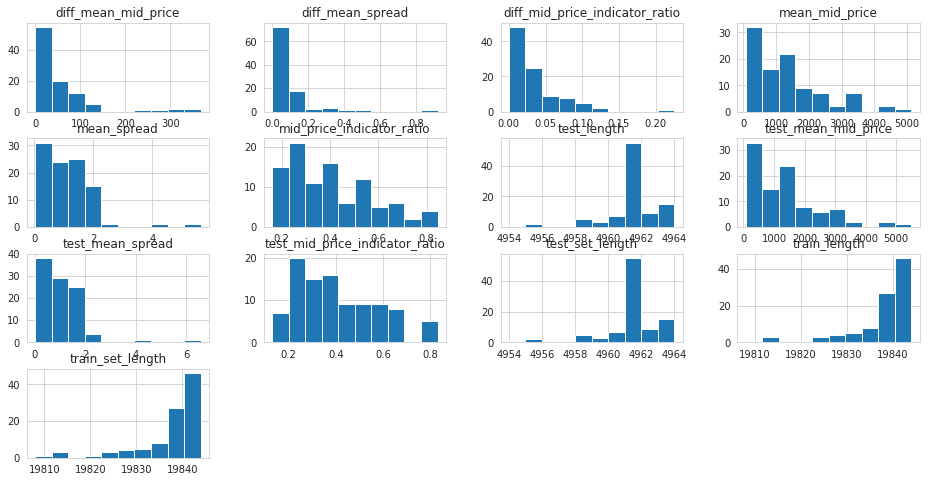

In [5]:
axes = df_stocks.hist(figsize=(16, 8))

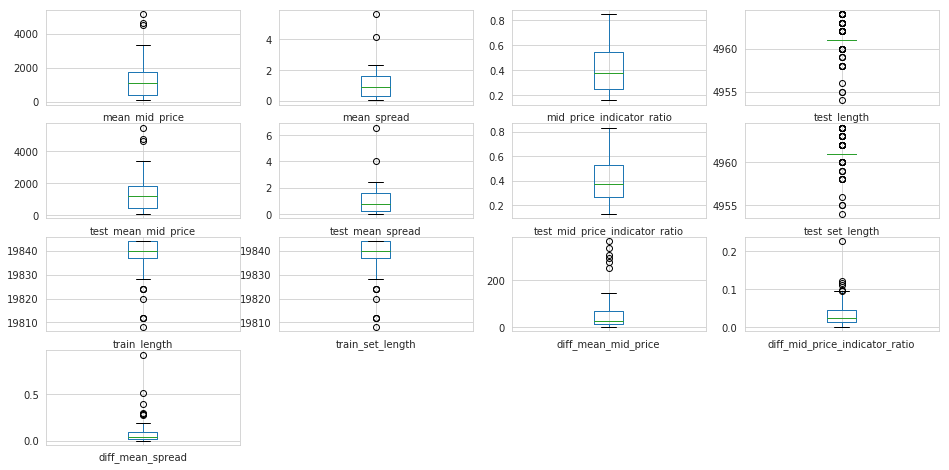

In [6]:
axes = df_stocks.plot(kind='box', subplots=True, layout=(4,4), figsize=(16, 8))

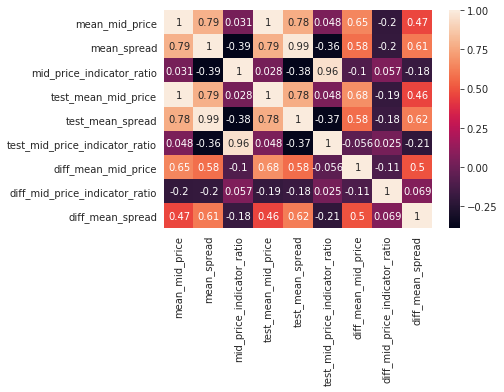

In [7]:
sns.heatmap(df_stocks[[c for c in df_stocks.columns if 'len' not in c]].corr(), annot=True)

In [8]:
df_stocks.head()

,mean_mid_price,mean_spread,mid_price_indicator_ratio,stock,test_dates,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,test_set_length,train_dates,train_length,train_set_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread
0,367.034464,0.104092,0.671214,9269,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,363.673695,0.086414,0.556323,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,3.360769,0.114892,0.017678
1,393.727832,0.207660,0.460191,3022,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,400.495152,0.163616,0.528977,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,6.767320,0.068785,0.044044
2,1289.914819,1.282359,0.189021,2051,"(2013-10-31 15:59:00, 2013-11-15 16:00:00)",4962,1305.862757,1.258767,0.201211,4962,"(2013-09-02 08:30:00, 2013-10-31 15:58:00)",19840,19840,15.947938,0.012190,0.023592
3,2456.725912,1.200665,0.399732,3879,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,2485.251562,1.175973,0.428571,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,28.525650,0.028839,0.024693
4,3134.476857,1.174032,0.685265,10166,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,3213.383945,1.239367,0.661642,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,78.907088,0.023624,0.065335


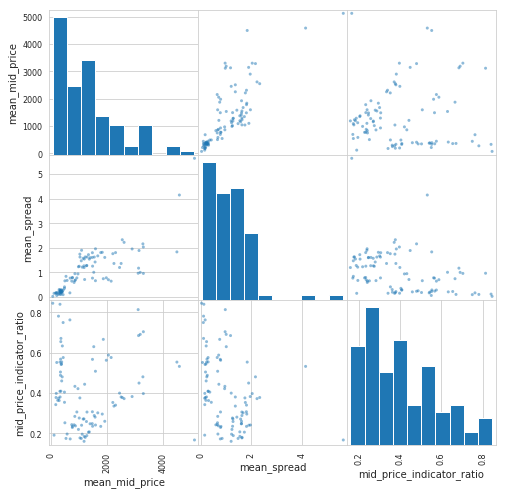

In [9]:
axes = scatter_matrix(
    df_stocks[[c for c in df_stocks.columns if 'len' not in c and 'test' not in c and 'diff' not in c]], 
    figsize=(8, 8))

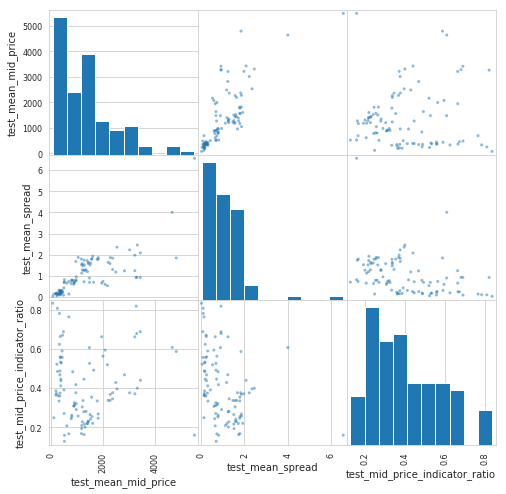

In [10]:
axes = scatter_matrix(
    df_stocks[[c for c in df_stocks.columns if 'len' not in c and 'test' in c and 'diff' not in c]], 
    figsize=(8, 8))

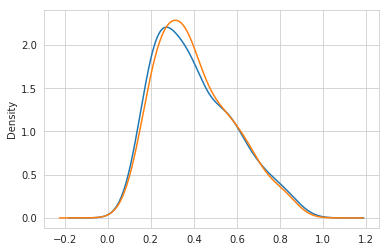

In [11]:
df_stocks['mid_price_indicator_ratio'].plot(kind='kde')
df_stocks['test_mid_price_indicator_ratio'].plot(kind='kde')

For most of the stocks the classes are inbalanced!

In [12]:
df_stocks.sort_values(by=['mid_price_indicator_ratio'], ascending=False).head(5)

,mean_mid_price,mean_spread,mid_price_indicator_ratio,stock,test_dates,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,test_set_length,train_dates,train_length,train_set_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread
83,75.765586,0.025592,0.845610,9064,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,75.722262,0.021665,0.832964,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,0.043324,0.012646,0.003927
85,333.112014,0.116947,0.840646,11244,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,332.133678,0.098660,0.780969,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,0.978336,0.059676,0.018288
28,3120.336399,0.966438,0.814060,9062,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,3266.279933,0.917456,0.818182,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,145.943535,0.004122,0.048982
18,279.191700,0.104359,0.781648,9069,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,253.523398,0.091282,0.806922,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,25.668303,0.025273,0.013077
87,686.151230,0.167577,0.762971,9061,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)",4961,691.633824,0.131546,0.763242,4961,"(2013-09-02 08:30:00, 2013-10-31 16:00:00)",19844,19844,5.482594,0.000271,0.036031


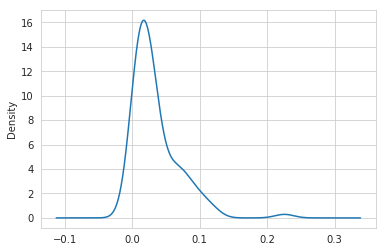

In [13]:
df_stocks['diff_mid_price_indicator_ratio'].plot(kind='kde')

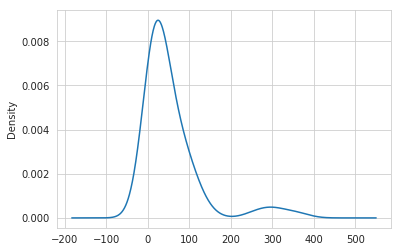

In [14]:
df_stocks['diff_mean_mid_price'].plot(kind='kde')

## Lets cluster

In [15]:
km = cluster.KMeans(n_clusters=3)
cols = ['mean_mid_price', 'mean_spread']
df_stocks['km'] = km.fit_predict(df_stocks[cols])

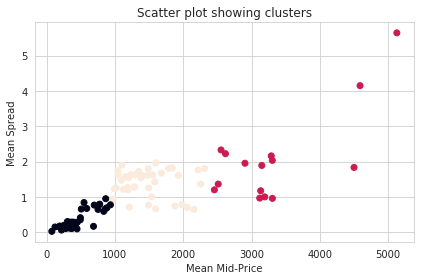

In [16]:
plt.scatter(x=df_stocks['mean_mid_price'], y=df_stocks['mean_spread'], c=df_stocks['km'])
plt.xlabel('Mean Mid-Price')
plt.ylabel('Mean Spread')
plt.title('Scatter plot showing clusters')
plt.tight_layout()
if should_savefig:
    plt.savefig('clusters.png')

In [17]:
for k in [0,1,2]:
    d = df_stocks[df_stocks['km'] == k]
    print(k)
    print(min(d['mean_mid_price']), max(d['mean_mid_price']))
    print(min(d['mean_spread']), max(d['mean_spread']))

0
75.76558607135676 934.1766759072581
0.025591614593824943 0.9490778068937714
1
2456.725912114493 5128.616355846774
0.959357992340254 5.6441028225806456
2
973.9084106027011 2314.3272177419353
0.6447036887724249 1.9618840872374799


### Choosing stocks

3 representative stocks one from each cluster.

5 stocks per cluster.

In [18]:
choosen_stocks = stocks_numbers.chosen_stocks

In [19]:
is_choosen = []
for i, row in df_stocks.iterrows():
    if row['stock'] in choosen_stocks:
        is_choosen.append(1)
    else:
        is_choosen.append(0)
df_stocks['is_choosen'] = is_choosen

In [20]:
df_stocks[df_stocks['is_choosen'] == 1][['stock', 'km']]

,stock,km
3,3879,1
19,3459,0
21,2748,1
28,9062,1
33,9761,2
39,11583,2
52,2822,2
55,10470,2
64,4799,2
69,1431,1


## Overview

In [21]:
if should_savefig:
    pd.DataFrame(choosen_stocks).to_csv('choosen_stocks.csv')
    df_stocks.to_csv('stocks.csv')

In [22]:
df_choosen = df_stocks[df_stocks['is_choosen'] == 1]
df_choosen[['test_dates', 'train_dates', 'test_set_length', 'train_set_length', 'stock', 'km']].groupby('km').head(1)

,test_dates,train_dates,test_set_length,train_set_length,stock,km
3,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)","(2013-09-02 08:30:00, 2013-10-31 16:00:00)",4961,19844,3879,1
19,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)","(2013-09-02 08:30:00, 2013-10-31 16:00:00)",4961,19844,3459,0
33,"(2013-11-01 08:30:00, 2013-11-15 16:00:00)","(2013-09-02 08:30:00, 2013-10-31 16:00:00)",4961,19844,9761,2


In [23]:
dfs = {}
stocks = df_choosen[[
    'test_dates', 'train_dates', 'test_set_length', 'train_set_length', 'stock', 'km']].groupby(
    'km').head(1)['stock'].values
for stock in stocks:
    df, _ = lob.load_prepared_data(stock, data_dir=data_dir, include_test=True)
    df['spread'] = (df['bid_price'] - df['ask_price'])
    df.index = pd.to_datetime(df['Unnamed: 0'].values)

    dfs[stock] = df

In [24]:
dfs[stocks[2]]['spread'].describe()

count    19844.000000
mean        -0.939125
std          1.861965
min         -4.000000
25%         -1.000000
50%         -1.000000
75%         -0.500000
max         99.500000
Name: spread, dtype: float64

19844
19844
19844


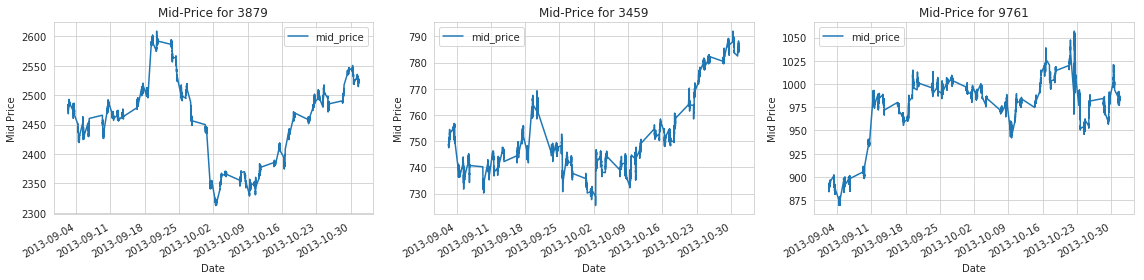

In [25]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(stocks)):
    print(len(dfs[stocks[i]]))
    dfs[stocks[i]][['mid_price']].plot(label=stocks[i], ax=ax[i])
    ax[i].set_title('Mid-Price for {}'.format(stocks[i]))
    ax[i].set_ylabel('Mid Price')
    ax[i].set_xlabel('Date')
    ax[i].legend()
plt.tight_layout()
plt.legend()
if should_savefig:
    print('Saving figure')
    plt.savefig('mid_price.png')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


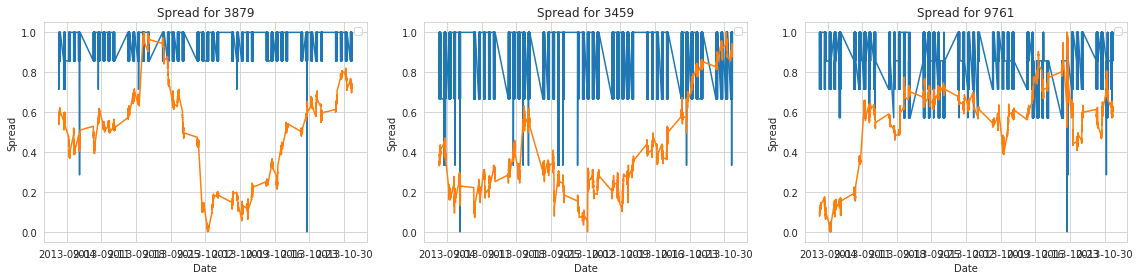

In [26]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))

from sklearn.preprocessing import MinMaxScaler
for i in range(len(stocks)):
    df = dfs[stocks[i]]
    df = df[df['spread'] < 20]
    scaler = MinMaxScaler()
    scaler.fit(df[['spread', 'mid_price']])
    scaled = scaler.transform(df[['spread', 'mid_price']])
    ax[i].plot(df.index, scaled[:, 0])
    ax[i].plot(df.index, scaled[:, 1])
    ax[i].set_title('Spread for {}'.format(stocks[i]))
    ax[i].set_ylabel('Spread')
    ax[i].set_xlabel('Date')
    ax[i].legend()
plt.tight_layout()
plt.legend()
if should_savefig:
    print('Saving figure')
    plt.savefig('spread.png')

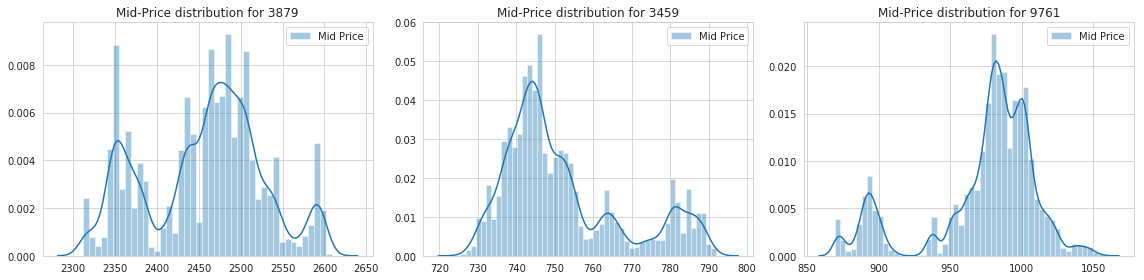

In [27]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(stocks)):
    sns.distplot(dfs[stocks[i]][['mid_price']], ax=ax[i], )
    ax[i].legend(['Mid Price'])
    ax[i].set_title('Mid-Price distribution for {}'.format(stocks[i]))
plt.tight_layout()
if should_savefig:
    plt.savefig('mid_price_distribution.png')

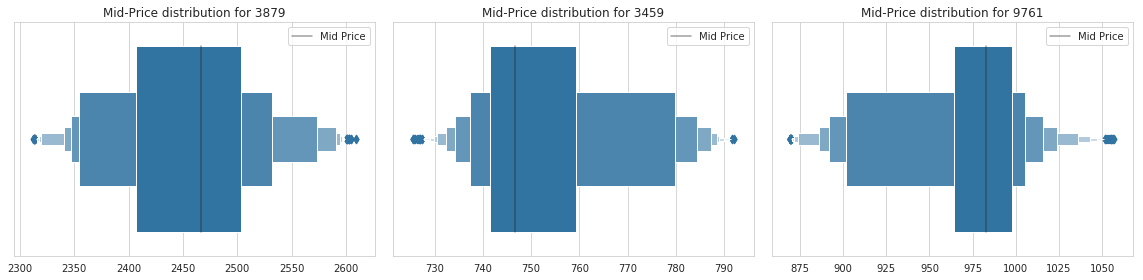

In [28]:
f, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(stocks)):
    sns.boxenplot(dfs[stocks[i]][['mid_price']], ax=ax[i])
    ax[i].legend(['Mid Price'])
    ax[i].set_title('Mid-Price distribution for {}'.format(stocks[i]))
plt.tight_layout()
if should_savefig:
    plt.savefig('mid_price_box_distribution.png')

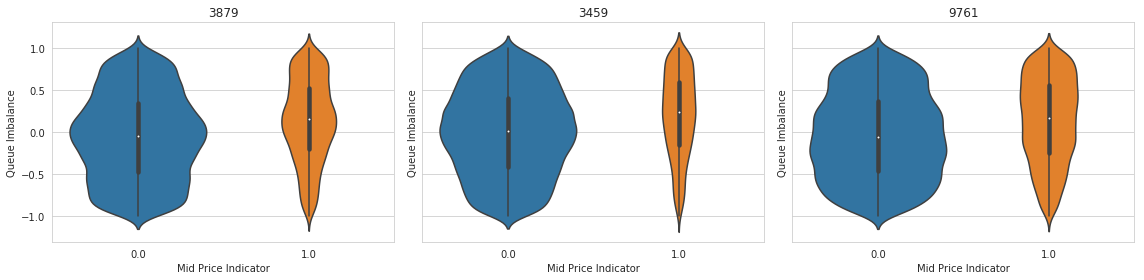

In [29]:
f, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
i = 0
plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')
for k, d in dfs.items():
    sns.violinplot(y=d['queue_imbalance'], x=d['mid_price_indicator'], ax=ax[i], scale="count", split=True)
    ax[i].set_title(k)
    ax[i].set_ylabel('Queue Imbalance')
    ax[i].set_xlabel('Mid Price Indicator')
    i += 1

plt.ylabel('Queue Imbalance')
plt.xlabel('Mid Price Indicator')
plt.tight_layout()
if should_savefig:
    plt.savefig('violin_plot_imb_vs_ind.png')

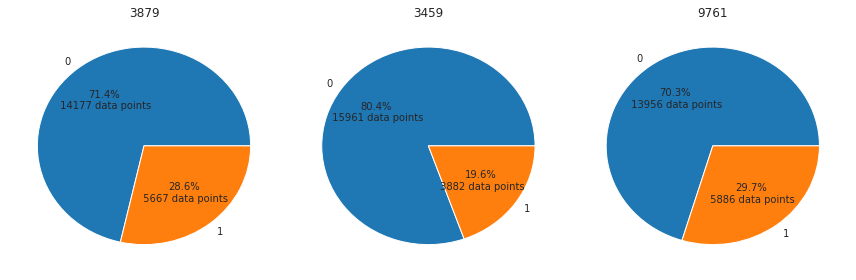

In [30]:
def format_pie_(pct, allvals):
    absolute = int(pct * np.sum(allvals) / 100.0)
    return "{:.1f}%\n {:d} data points".format(pct, absolute)

f, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for i in range(len(stocks)):
    df = dfs[stocks[i]]
    sizes = [len(df[df['mid_price_indicator'] == 0.0]), len(df[df['mid_price_indicator'] == 1.0]), ]
    ax[i].pie(sizes, labels=['0', '1'], autopct=lambda pct: format_pie_(pct, sizes))
    ax[i].set_title(stocks[i])
plt.tight_layout()
if should_savefig:
    plt.savefig('pie_plot_mid_price_indicator.png')

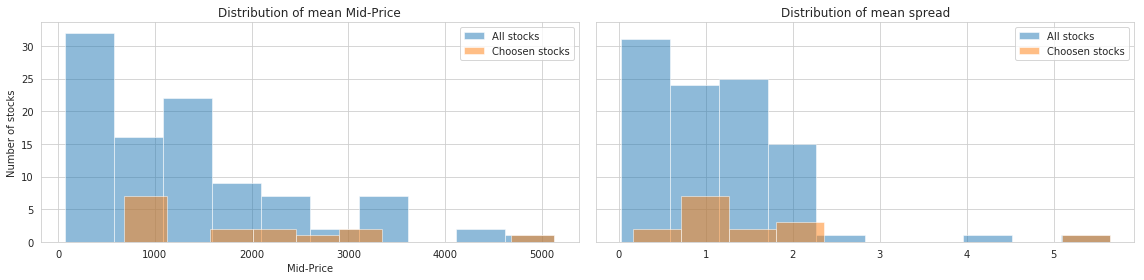

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

df_stocks['mean_mid_price'].hist(label='All stocks', ax=ax1, alpha=0.5) 
df_choosen['mean_mid_price'].hist(label='Choosen stocks', ax=ax1, alpha=0.5)
df_stocks['mean_spread'].hist(label='All stocks', ax=ax2, alpha=0.5) 
df_choosen['mean_spread'].hist(label='Choosen stocks', ax=ax2, alpha=0.5)
ax1.legend()
ax2.legend()
ax1.set_title('Distribution of mean Mid-Price')
ax2.set_title('Distribution of mean spread')
ax1.set_xlabel('Mid-Price')
ax1.set_ylabel('Number of stocks')
plt.tight_layout()
if should_savefig:
    plt.savefig('choosen_stock_dist.png')